In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
TARGET_COL = "genre_top"
N_SPLITS = 5

## Load merged dataset

In [3]:
df_train = pd.read_csv("../DataBase/processed/train_data.csv")
print(df_train.shape)

df_test = pd.read_csv("../DataBase/processed/test_data.csv")
print(df_test.shape)

(5493, 41)
(1374, 41)


## Data preprocessing

In [4]:
df_train = df_train[df_train[TARGET_COL].notna()].dropna().copy()
print(df_train.shape)

df_test = df_test[df_test[TARGET_COL].notna()].dropna().copy()
print(df_test.shape)

(5493, 41)
(1374, 41)


In [5]:
count_genre_top = df_train[TARGET_COL].value_counts()
rare_labels = count_genre_top[count_genre_top < 100].index
df_train = df_train[~df_train[TARGET_COL].isin(rare_labels)].copy()
print(df_train.shape)

df_test = df_test[~df_test[TARGET_COL].isin(rare_labels)].copy()
print(df_test.shape)

(5290, 41)
(1324, 41)


In [6]:
label_encoder = LabelEncoder()
df_train["genre_top"] = label_encoder.fit_transform(df_train["genre_top"])
df_test["genre_top"] = label_encoder.transform(df_test["genre_top"])

mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(mapping)

{'Classical': np.int64(0), 'Electronic': np.int64(1), 'Folk': np.int64(2), 'Hip-Hop': np.int64(3), 'Jazz': np.int64(4), 'Old-Time / Historic': np.int64(5), 'Pop': np.int64(6), 'Rock': np.int64(7)}


In [7]:
X_train, X_test = df_train.drop(columns=[TARGET_COL]), df_test.drop(columns=[TARGET_COL])
y_train, y_test = df_train[TARGET_COL], df_test[TARGET_COL]

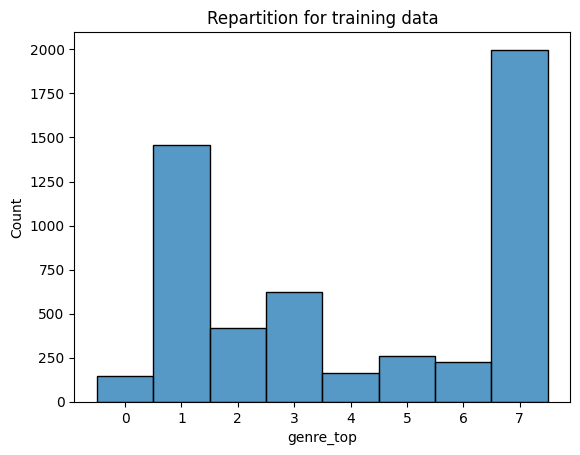

In [8]:
ax = sns.histplot(y_train, discrete=True)
ax.set_title("Repartition for training data")
plt.show()

## Model training

In [9]:
k_fold = KFold(N_SPLITS)

In [10]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

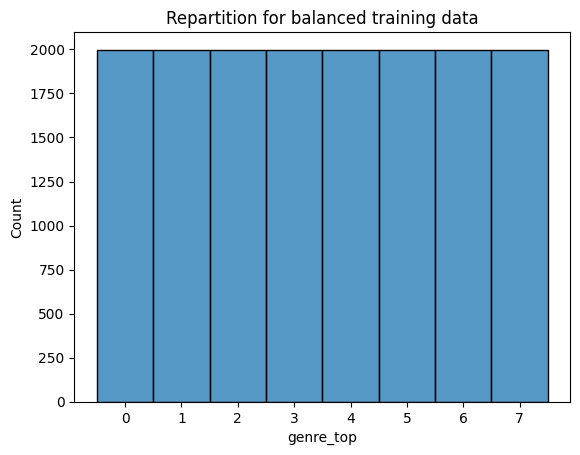

In [11]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

ax = sns.histplot(y_train_balanced, discrete=True)
ax.set_title("Repartition for balanced training data")
plt.show()

### Random Forest

#### Training with basic hyperparams

In [ ]:
random_forest = RandomForestClassifier(
    random_state=42,
    class_weight=class_weights_dict,
)

random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        37
           1       0.73      0.77      0.75       364
           2       0.66      0.38      0.48       106
           3       0.85      0.65      0.73       156
           4       0.89      0.20      0.33        40
           5       1.00      0.97      0.98        65
           6       0.80      0.07      0.13        56
           7       0.70      0.89      0.78       500

    accuracy                           0.74      1324
   macro avg       0.80      0.60      0.62      1324
weighted avg       0.75      0.74      0.71      1324



In [13]:
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(X_train_balanced, y_train_balanced)
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82        37
           1       0.77      0.74      0.76       364
           2       0.50      0.65      0.57       106
           3       0.73      0.78      0.76       156
           4       0.46      0.45      0.46        40
           5       0.98      0.98      0.98        65
           6       0.38      0.36      0.37        56
           7       0.81      0.77      0.79       500

    accuracy                           0.74      1324
   macro avg       0.68      0.70      0.69      1324
weighted avg       0.75      0.74      0.74      1324



In [14]:
random_forest = RandomForestClassifier(random_state=42)

scores = cross_validate(random_forest, X_train_balanced, y_train_balanced, cv=k_fold, scoring="accuracy")["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.752 +- 0.099


#### Training with hyperparams optimization

In [15]:
PARAM_GRID = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None], # None permet aux arbres de se développer pleinement
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [16]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= k_fold,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  12.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  12.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  12.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  12.4s
[CV] END max_depth=10, min_sa

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [17]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best CV score (based on training data): 0.7579
              precision    recall  f1-score   support

           0       0.76      0.92      0.83        37
           1       0.77      0.74      0.76       364
           2       0.53      0.66      0.59       106
           3       0.74      0.78      0.76       156
           4       0.49      0.50      0.49        40
           5       0.97      0.97      0.97        65
           6       0.46      0.41      0.43        56
           7       0.82      0.78      0.80       500

    accuracy                           0.75      1324
   macro avg       0.69      0.72      0.70      1324
weighted avg       0.75      0.75      0.75      1324



### XGBoost

#### Training with basic hyperparams

In [ ]:
xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=class_weights_dict,
)

xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
print(confusion_matrix(y_test, predictions))

/Users/antoinekerboul/Documents/IMT_Atlantique/4A/FML/Challenges/supervised-challenge/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:00:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.83      0.78      0.81        37
           1       0.79      0.83      0.81       364
           2       0.80      0.60      0.69       106
           3       0.87      0.82      0.84       156
           4       0.87      0.50      0.63        40
           5       0.97      0.95      0.96        65
           6       0.74      0.30      0.43        56
           7       0.79      0.90      0.84       500

    accuracy                           0.81      1324
   macro avg       0.83      0.71      0.75      1324
weighted avg       0.81      0.81      0.80      1324

[[ 29   4   0   0   1   2   0   1]
 [  0 302   7   6   1   0   0  48]
 [  1   7  64   4   0   0   0  30]
 [  0  17   1 128   0   0   1   9]
 [  4   3   2   0  20   0   0  11]
 [  1   1   0   0   1  62   0   0]
 [  0  12   1   3   0   0  17  23]
 [  0  36   5   6   0   0   5 448]]


In [19]:
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train_balanced, y_train_balanced)
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.80      0.80      0.80       364
           2       0.65      0.62      0.64       106
           3       0.85      0.81      0.83       156
           4       0.58      0.62      0.60        40
           5       0.97      0.98      0.98        65
           6       0.45      0.41      0.43        56
           7       0.82      0.83      0.82       500

    accuracy                           0.79      1324
   macro avg       0.74      0.74      0.74      1324
weighted avg       0.79      0.79      0.79      1324

[[ 32   1   0   0   1   1   0   2]
 [  1 292   9  10   4   0  10  38]
 [  1   4  66   3   0   1   6  25]
 [  0  16   1 126   2   0   1  10]
 [  4   3   5   0  25   0   0   3]
 [  1   0   0   0   0  64   0   0]
 [  0  10   3   3   1   0  23  16]
 [  0  38  17   7  10   0  11 417]]


In [20]:
xgb = XGBClassifier(random_state=42)

scores = cross_validate(xgb, X_train_balanced, y_train_balanced, cv=k_fold, scoring="accuracy")["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.811 +- 0.053


#### Training with hyperparams optimization

In [21]:
PARAM_GRID = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 5],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

In [22]:
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= k_fold,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   7.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   7.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   7.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   7.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   7.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   7.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.9], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, ...], 'min_child_weight': [1, 5], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [23]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))

Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.7}
Best CV score (based on training data): 0.8523
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        37
           1       0.81      0.82      0.81       364
           2       0.66      0.63      0.64       106
           3       0.85      0.82      0.83       156
           4       0.69      0.72      0.71        40
           5       0.97      0.98      0.98        65
           6       0.55      0.48      0.51        56
           7       0.83      0.84      0.84       500

    accuracy                           0.81      1324
   macro avg       0.78      0.77      0.77      1324
weighted avg       0.80      0.81      0.80      1324

